In [3]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Comparison on multiple datasets

In [4]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [5]:
import sys
sys.path.append('./EXPLAN')
import explan
from utils import *
from LORE import lore
from LORE.neighbor_generator import *

In [6]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [7]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [8]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [9]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    y_test_appended = np.concatenate([y_test,[1]])
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [10]:
shap.initjs()

In [11]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [12]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [13]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

Accuracy  model: 0.667739340305712 for data_rl
Train size: 3727
----------- Model certainty for instance: 0.8081919593484376 ---------------
Neighbourhood size: 124
Average distace of neighbourhood: 1.3938318772301137.
Train sample size: 433 (0.11617923262677757)


Permutation explainer: 435it [02:09,  3.10it/s]                                                                                                                    


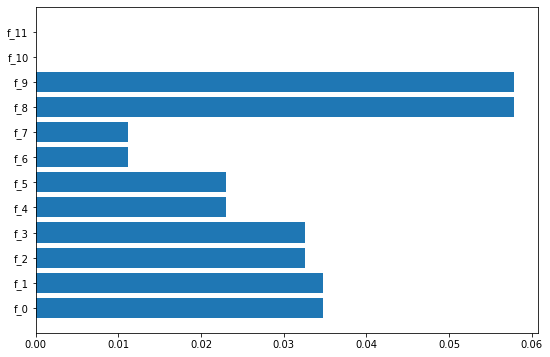

In [57]:
import time
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
rs=42
init_fraction=0.1
#directory = './data/numerical_only/balanced'
directory = './data/num_and_cat/balanced'
up=True
depth = 2
SAMPLE_SIZE=1
show=True
ismpl=True
synthetic = False
density_sampling=False#True
radius_sampling=False#True
oversampling=False
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
n_jobs=-1

for num_and_cat in  os.listdir(directory):

    clf_basic  = MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
    #clf = svm.SVC(probability=True,random_state=rs)
    if directory =='./data/numerical_only/balanced':
        (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        categorical_indicator=[False]*len(features)
        clf = clf_basic
    else:
        (data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        categories_data = data[:,categorical_indicator]
        categories=[np.unique(categories_data[:,i]).astype(int) for i in np.arange(categories_data.shape[1])]
        clf = CategoricalWrapper(clf_basic, None, categorical_indicator, features, categories=categories)
        
    continuous_indicator = np.logical_not(categorical_indicator)
    target = 'class'
    df = pd.DataFrame(data,columns=features,dtype=float)
    sc = StandardScaler()
    df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
    df[target] = y
    
    if synthetic: 
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=8, 
                                              n_informative=6, n_redundant=2, n_repeated=0, n_clusters_per_class=3,
                                              n_classes=2)
        features = [f'x{i}' for i in range(1,X.shape[1]+1)]
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        
        
    if num_and_cat in ['data_Higgs','data_covertype','data_MiniBooNE']:
        continue
    if len(df) >6000:
        fraction = 1000.0/len(df)
    else:
        fraction = init_fraction
        
    
    
    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    print(f'Train size: {len(train)}')
    
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)
        #explain_instance = test[features].sample(1).values#.astype('f8')    
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
    
        # distances = sklearn.metrics.pairwise_distances(test[features], explain_instance)
        # pd.DataFrame(distances).hist()
        # plt.show()
        # _,borders = np.histogram(distances)
        # idxs,_ = np.where(distances<=borders[2])
        # dfneigh = test.iloc[idxs]
        # print(f'Neighbourhood size: {len(dfneigh)}')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        
        
        ##############for testing dectree on the bbox sample################
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  
                  node_size_limit = 2, grow_confidence_threshold = 0)
        X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                  X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                  use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                 representative=representative,density_sampling=density_sampling,n_jobs=-1)
        print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
        ###################################################################
        #shap on this sample
        #append pint as a first element and plot force plot
        X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        try:
            explainer = shap.Explainer(clf, X_shap)
            shap_values = explainer.shap_values(X_shap)
            shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0,:],feature_names = features )
            vals= np.abs(shap_values).mean(0).mean(0)
        except TypeError:
            explainer = shap.Explainer(clf.predict_proba, X_shap)
            shap_values_obj = explainer(X_shap)
            shap_values=shap_values_obj.values
            (samples,nfeatures,nclasses) = shap_values.shape
            shap_values=np.array([abs(sv).mean(1) for sv in shap_values])
            vals= np.abs(shap_values).mean(0)
            plt.figure(figsize=(9,6))
            plt.barh(features ,vals)
            plt.show()
            
        
        break
        
        #take N most relevant features and focus only on these when building explanations

        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator)
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))

        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                                                #class_names=['0', '1'] ,
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))

        dectree_score =  accuracy_score(clf_dtree.predict(dfneigh[features]),clf.predict(dfneigh[features]))
        print(f'Fidelity  dectree: {dectree_score}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        print(f'Accuracy  dectree: {dectree_score_acc}')
       

        print('Lux ww proba')
        start_time = time.time()
        #explain xgboost without proba, 
        lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0)
        lux.attributes_names=X_train_sample.columns
        #This is commented out for the computational efficiency of the benchmark
        #lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up,oversampling=oversampling,representative=representative,
        #        radius_sampling=radius_sampling, inverse_sampling=ismpl ,density_sampling=density_sampling, n_jobs=-1,
        #       uncertain_entropy_evaluator=uncertain_entropy_evaluator)
        
        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        lux.uid3.PARALLEL_ENTRY_FACTOR = 100
        if lux.classifier is not None:
            lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs)


        #calculate decision tree score over this dataset
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        if synthetic and X_train_sample.shape[1] == 2:
            decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_pure = accuracy_score(predictions, clf.predict(dfneigh[features]))
        prec_score_pure = precision_score(clf.predict(dfneigh[features]),predictions)
        rec_score_pure = recall_score(clf.predict(dfneigh[features]),predictions)
        f1_score_pure = f1_score(clf.predict(dfneigh[features]),predictions)
        print(f'Fidelity  no proba: {ac_score_pure}')
        ac_score_pure_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  no proba: {ac_score_pure_acc}')
        
        
        justification = lux.justify(explain_instance)[0]
        ats_no_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
        importance_gain_noproba = shapfeatures[shapfeatures['col_name'].isin(ats_no_proba)]['feature_importance_vals'].sum()/len(ats_no_proba)

        print('Lux w proba')
        start_time = time.time()
        #with proba, 
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.attributes_names=X_train_sample.columns
        #lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up, 
        #        uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,representative=representative,
        #        radius_sampling=radius_sampling,inverse_sampling= ismpl,density_sampling=density_sampling, n_jobs=-1)
        
        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        lux.uid3.PARALLEL_ENTRY_FACTOR = 100
        if lux.classifier is not None:
            lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs)
            
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
       # decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


        print("--- %s seconds ---" % (time.time() - start_time))
        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_proba = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with proba: {ac_score_proba}')
        ac_score_proba_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  with proba: {ac_score_proba_acc}')
        prec_score_proba = precision_score(clf.predict(dfneigh[features]),predictions)
        rec_score_proba = recall_score(clf.predict(dfneigh[features]),predictions)
        f1_score_proba = f1_score(clf.predict(dfneigh[features]),predictions)

        justification = lux.justify(explain_instance)[0]
        ats_with_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
        importance_gain_with_proba = shapfeatures[shapfeatures['col_name'].isin(ats_with_proba)]['feature_importance_vals'].sum()/len(ats_with_proba)
        
        print('Lux w shap')
        start_time = time.time()
        lux = LUX(classifier = clf,predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.attributes_names=X_train_sample.columns
        # lux.fit(train[features], train[target], 
        #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
        #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
        #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )
        
        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        lux.uid3.PARALLEL_ENTRY_FACTOR = 100
        if lux.classifier is not None:
            lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,depth=0,beta=1,n_jobs=n_jobs)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,n_jobs=n_jobs)

        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

        print("--- %s seconds ---" % (time.time() - start_time))
        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_shap = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with shap: {ac_score_shap}')
        ac_score_shap_acc = accuracy_score(predictions, dfneigh[target])
        print(f'Accuracy  with shap: {ac_score_shap_acc}')
        prec_score_shap = precision_score(clf.predict(dfneigh[features]),predictions)
        rec_score_shap = recall_score(clf.predict(dfneigh[features]),predictions)
        f1_score_shap = f1_score(clf.predict(dfneigh[features]),predictions)
        
        justification = lux.justify(explain_instance)[0]
        ats_shap= [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
        importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
        
        ########################################################## ###### #######################################################
        ########################################################## EXPLAN #######################################################
        #X_train_sample['class'] = np.argmax(y_train_sample,axis=1)
        myds = prepare_ds(train,discrete=categorical_indicator)
        X, y = myds['X'], myds['y']
        instance2explain = explain_instance.ravel()

        # EXPLAN hyper-parameters
        N_samples = 3000#n_neighbors
        tau = 250#int(n_neighbors)/len(np.unique(df[target])

        # Explaining instance x using EXPLAN
        exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                                   clf,
                                                   myds,
                                                   N_samples=N_samples,
                                                   tau=tau,depth=depth)

        explan_y=pyyadt.predict(info_EXPLAN['C'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
        ac_score_explan = accuracy_score(explan_y[0], clf.predict(dfneigh[features]))
        print(f'Fidelity  EXPLAN: {ac_score_explan}')
        ac_score_explan_acc = accuracy_score(explan_y[0], dfneigh[target])
        print(f'Accuracy  EXPLAN: {ac_score_explan_acc}')
        print('EXPLAN expl e = %s' % exp_EXPLAN[1])
        prec_score_explan = precision_score(clf.predict(dfneigh[features]),explan_y[0])
        rec_score_explan = recall_score(clf.predict(dfneigh[features]),explan_y[0])
        f1_score_explan = f1_score(clf.predict(dfneigh[features]),explan_y[0])
        
        
        ats_explan = list(exp_EXPLAN[1].keys())
        importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)
        
        
        ########################################################## ###### #######################################################
        ########################################################## LORE #########################################################
        try:
            X_explain = np.concatenate(([instance2explain], myds['X']))
            exp_LORE, info_LORE = lore.explain(0, X_explain,
                                               myds, clf,
                                               ng_function=genetic_neighborhood,
                                               discrete_use_probabilities=True,
                                               continuous_function_estimation=False,
                                               returns_infos=True, path='./EXPLAN/yadt/',
                                               sep=';', log=False)


            lore_y=pyyadt.predict(info_LORE['dt'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
            ac_score_lore = accuracy_score(lore_y[0], clf.predict(dfneigh[features]))
            print(f'Fidelity  LORE: {ac_score_lore}')
            ac_score_lore_acc = accuracy_score(lore_y[0], dfneigh[target])
            print(f'Accuracy  LORE: {ac_score_lore_acc}')
            print('LORE expl e = %s' % exp_LORE[1])
            prec_score_lore = precision_score(clf.predict(dfneigh[features]),lore_y[0])
            rec_score_lore = recall_score(clf.predict(dfneigh[features]),lore_y[0])
            f1_score_lore = f1_score(clf.predict(dfneigh[features]),lore_y[0])


            ats_lore = list(exp_LORE[0][1].keys())
            importance_gain_lore = shapfeatures[shapfeatures['col_name'].isin(ats_lore)]['feature_importance_vals'].sum()/len(ats_lore)
        except:
            importance_gain_lore = prec_score_lore =rec_score_lore=f1_score_lore=ac_score_lore_acc=-1
            
            print('LORE failed...')

        
        ########################################################## ###### #######################################################
        ########################################################## ANCHOR #######################################################
        
        try:
            X_explain = np.concatenate(([instance2explain], myds['X']))
            anchor_explainer = fit_anchor(myds, train[features], test[features], train[target], test[target], X_explain)
            exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                        clf.predict, threshold=0.95)

            ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature']]
            importance_gain_anchor = shapfeatures[shapfeatures['col_name'].isin(ats_anchor)]['feature_importance_vals'].sum()/len(ats_anchor)
        except:
            print('Anchor failed...')
            importance_gain_anchor=0
    

        ########################################################## ###### #######################################################
        ########################################################## ###### #######################################################
        
        #TODO: save instance2explain (need in calculating stability) every time it loops over the dataset
        #TODO: hit metric

        features_data.append([num_and_cat,num_and_cat,shapfeatures['col_name'].values,ats_no_proba,ats_with_proba,ats_shap,ats_explan])
        #stability.append()
        
        imp_fid_data.append([num_and_cat,num_and_cat,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan,importance_gain_lore,importance_gain_anchor])
        fid_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure,ac_score_proba,ac_score_shap, model_score, dectree_score,ac_score_explan,ac_score_lore,
                        prec_score_pure,prec_score_proba,prec_score_shap,prec_score_explan,prec_score_lore,
                        rec_score_pure,rec_score_proba,rec_score_shap,rec_score_explan,rec_score_lore,
                        f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan,f1_score_lore])
        nac_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc,ac_score_lore_acc
                         ])
    ## save results        
    break

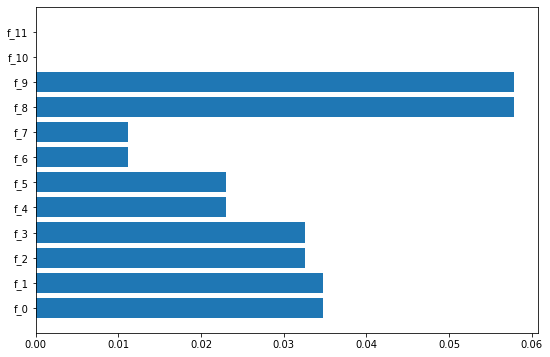

In [58]:
shap_values=shap_values_obj.values
(samples,nfeatures,nclasses) = shap_values.shape
shap_values=[sv for sv in shap_values.reshape(nclasses,samples,nfeatures)]
vals= np.abs(shap_values).mean(0).mean(0)
plt.figure(figsize=(9,6))
plt.barh(features ,vals)
plt.show()

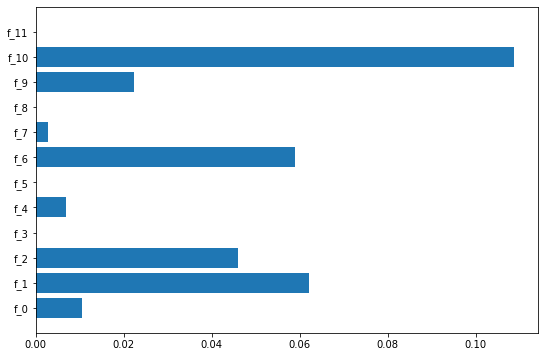

In [76]:
shap_values=shap_values_obj.values
(samples,nfeatures,nclasses) = shap_values.shape
shap_values=np.array([abs(sv).mean(1) for sv in shap_values])
vals= np.abs(shap_values).mean(0)
plt.figure(figsize=(9,6))
plt.barh(features ,vals)
plt.show()

In [81]:
shap_values=shap_values_obj.values
shap_values.shape

(434, 12, 2)

In [84]:
svr = np.array([sv for sv in shap_values.reshape(nclasses,samples,nfeatures)])
svr.shape

(2, 434, 12)

In [85]:
svr[0,0,:]

array([-0.00330921,  0.00330921, -0.04143899,  0.04143899, -0.1014351 ,
        0.1014351 ,  0.        ,  0.        ,  0.00135332, -0.00135332,
        0.        ,  0.        ])

In [86]:
shap_values[0,:,0]

array([-0.00330921, -0.04143899, -0.1014351 ,  0.        ,  0.00135332,
        0.        , -0.02359621, -0.00160804,  0.        , -0.00960856,
       -0.09856321,  0.        ])

<BarContainer object of 12 artists>

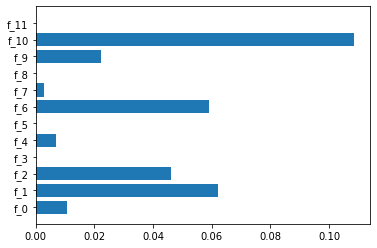

In [75]:
plt.barh(features, dd.mean(0))

<AxesSubplot:xlabel='dataset'>

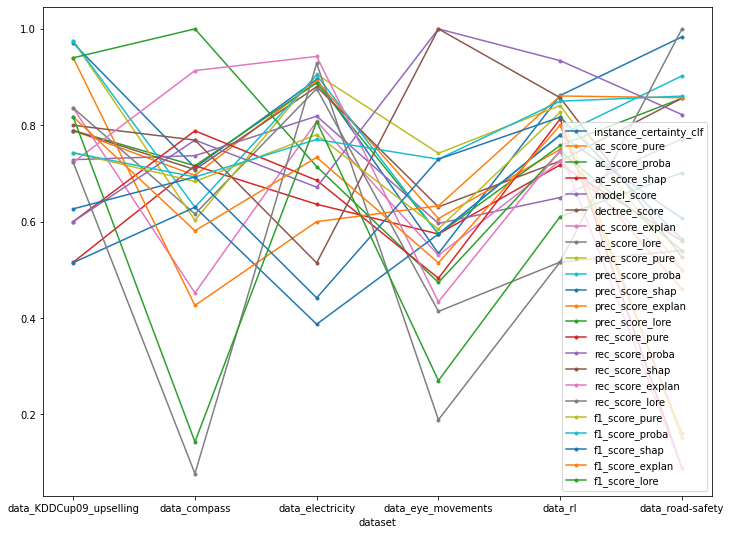

In [22]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score','ac_score_explan','ac_score_lore',
                                             'prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                        'rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                        'f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore'])
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(12,9))


In [23]:
#results_fid.to_csv("allx100.csv",index=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'instance_certainty_clf'),
  Text(1, 0, 'ac_score_pure'),
  Text(2, 0, 'ac_score_proba'),
  Text(3, 0, 'ac_score_shap'),
  Text(4, 0, 'model_score'),
  Text(5, 0, 'dectree_score'),
  Text(6, 0, 'ac_score_explan'),
  Text(7, 0, 'ac_score_lore'),
  Text(8, 0, 'prec_score_pure'),
  Text(9, 0, 'prec_score_proba'),
  Text(10, 0, 'prec_score_shap'),
  Text(11, 0, 'prec_score_explan'),
  Text(12, 0, 'prec_score_lore'),
  Text(13, 0, 'rec_score_pure'),
  Text(14, 0, 'rec_score_proba'),
  Text(15, 0, 'rec_score_shap'),
  Text(16, 0, 'rec_score_explan'),
  Text(17, 0, 'rec_score_lore'),
  Text(18, 0, 'f1_score_pure'),
  Text(19, 0, 'f1_score_proba'),
  Text(20, 0, 'f1_score_shap'),
  Text(21, 0, 'f1_score_explan'),
  Text(22, 0, 'f1_score_lore')])

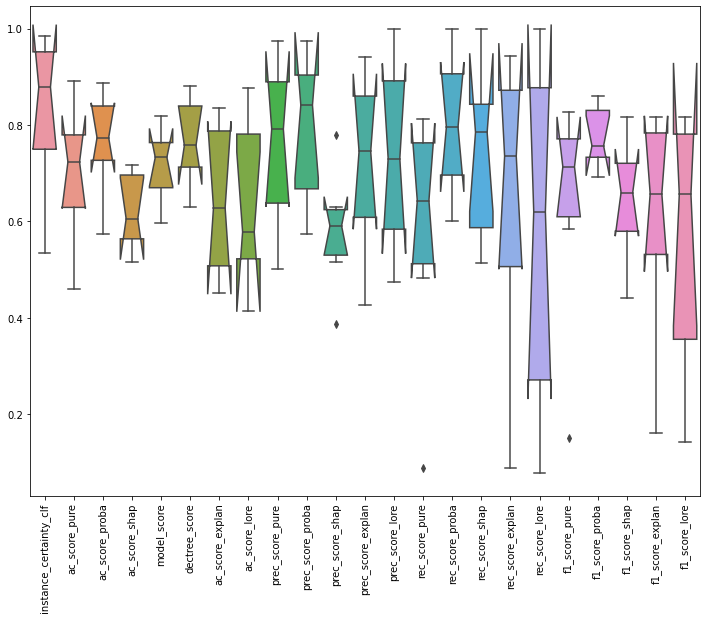

In [24]:
#all-one
plt.figure(figsize=(12,9))
sns.boxplot(data=results_fid.groupby('dataset').mean(), notch=True)
plt.xticks(rotation=90)

In [20]:
#all-one
results_fid.mean()

instance_certainty_clf    0.826210
ac_score_pure             0.698915
ac_score_proba            0.763571
ac_score_shap             0.619944
model_score               0.717124
dectree_score             0.764899
ac_score_explan           0.641977
ac_score_lore             0.632954
prec_score_pure           0.761074
prec_score_proba          0.794220
prec_score_shap           0.582167
prec_score_explan         0.719427
prec_score_lore           0.735667
rec_score_pure            0.576462
rec_score_proba           0.799491
rec_score_shap            0.744431
rec_score_explan          0.641517
rec_score_lore            0.572311
f1_score_pure             0.628197
f1_score_proba            0.774341
f1_score_shap             0.645117
f1_score_explan           0.601227
f1_score_lore             0.558232
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'instance_certainty_clf'),
  Text(1, 0, 'ac_score_pure'),
  Text(2, 0, 'ac_score_proba'),
  Text(3, 0, 'ac_score_shap'),
  Text(4, 0, 'model_score'),
  Text(5, 0, 'dectree_score'),
  Text(6, 0, 'ac_score_explan'),
  Text(7, 0, 'ac_score_lore'),
  Text(8, 0, 'prec_score_pure'),
  Text(9, 0, 'prec_score_proba'),
  Text(10, 0, 'prec_score_shap'),
  Text(11, 0, 'prec_score_explan'),
  Text(12, 0, 'prec_score_lore'),
  Text(13, 0, 'rec_score_pure'),
  Text(14, 0, 'rec_score_proba'),
  Text(15, 0, 'rec_score_shap'),
  Text(16, 0, 'rec_score_explan'),
  Text(17, 0, 'rec_score_lore'),
  Text(18, 0, 'f1_score_pure'),
  Text(19, 0, 'f1_score_proba'),
  Text(20, 0, 'f1_score_shap'),
  Text(21, 0, 'f1_score_explan'),
  Text(22, 0, 'f1_score_lore')])

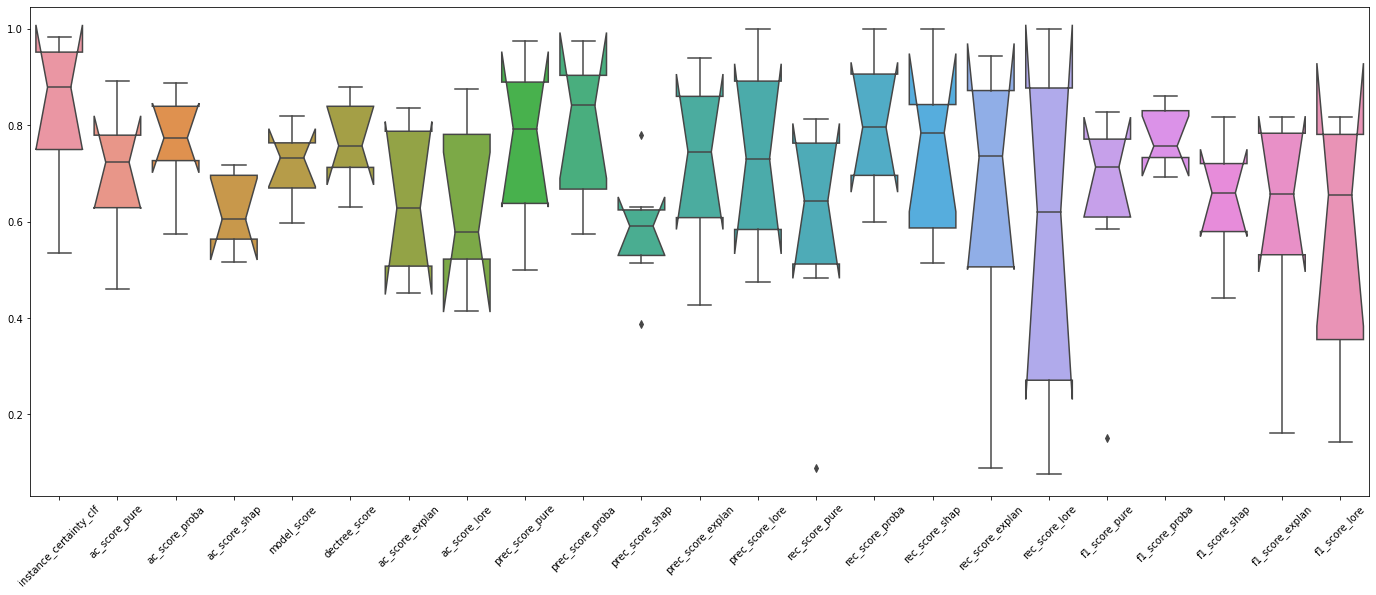

In [21]:
#one-s
fig, ax = plt.subplots(figsize=(24,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)
plt.xticks(rotation=45)

In [ ]:
results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor'])
results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(12,9))
                       

In [ ]:
#results_imp_fid.to_csv("allx100_imp.csv",index=False)

In [ ]:
results_imp_fid.mean()

In [ ]:
#one-shot
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=True,ax=ax)

In [ ]:
results.to_csv('results_background_subset_set_real_f02n02.csv',index=False)

In [ ]:
# directory = ['./data/numerical_only/balanced', './data/num_and_cat/balanced']
# for d in directory:
#     for num_and_cat in  os.listdir(d):
#         if d == './data/num_and_cat/balanced':
#             (data, y, categorical_indicator) = pickle.load(open(f'{d}/{num_and_cat}','rb'))
#         else:
#             (data, y) = pickle.load(open(f'{d}/{num_and_cat}','rb'))
#             categorical_indicator=[False]*len(features)
#         features = [f'f_{i}' for i in range(0,data.shape[1])]
#         continuous_indicator = np.logical_not(categorical_indicator)
#         target = 'class'
#         df = pd.DataFrame(data,columns=features,dtype=float)
#         df[target] = y
#         df.to_csv(f'./tmp/{num_and_cat}.csv',index=False)
        